In [ ]:
import sys
!{sys.executable} -m pip install wrds

In [ ]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import argparse

# Données
import wrds

#2.1
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error

#2.2
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

#2.3 
import statsmodels.api as sm


In [17]:
db = wrds.Connection(wrds_username='lilas_bertot')

Loading library list...
Done


# PRÉPARATION DES DONNÉES UTILISÉES

In [18]:
spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi
WHERE date >= '2010-01-01'
AND spindx IS NOT NULL
ORDER BY date;
"""
spx_data = db.raw_sql(spx_query, date_cols=['date'])
spx_data = spx_data.rename(columns={'prc': 'SP500'})
spx_data['date'] = pd.to_datetime(spx_data['date'])

print(spx_data)
print("Nombre d’observations :", len(spx_data))

           date    SP500
0    2010-01-04  1132.99
1    2010-01-05  1136.52
2    2010-01-06  1137.14
3    2010-01-07  1141.69
4    2010-01-08  1144.98
...         ...      ...
3769 2024-12-24  6040.04
3770 2024-12-26  6037.59
3771 2024-12-27  5970.84
3772 2024-12-30  5906.94
3773 2024-12-31  5881.63

[3774 rows x 2 columns]
Nombre d’observations : 3774


In [19]:
# téléchargement indices boursier 3 marchés développés: DAX (Allemagne), Nikkei225 (Japon), FTSE100 (Royaume-Uni)
# téléchargement indices boursier 2 marchés émergents: Bovespa (Brésil), Nifty50 (Inde)

intern_indices_query = """
SELECT 
    datadate,
    MAX(CASE WHEN gvkeyx = '150095' THEN prccd END) AS DAX,
    MAX(CASE WHEN gvkeyx = '150008' THEN prccd END) AS FTSE100,
    MAX(CASE WHEN gvkeyx = '150069' THEN prccd END) AS Nikkei225,
    MAX(CASE WHEN gvkeyx = '150086' THEN prccd END) AS Bovespa,
    MAX(CASE WHEN gvkeyx = '151120' THEN prccd END) AS Nifty50
FROM comp.g_idx_daily
WHERE gvkeyx IN ('150095', '150008', '150069', '150086', '151120')
  AND datadate >= '2010-01-01'
  AND prccd IS NOT NULL
GROUP BY datadate
ORDER BY datadate
"""
intern_indices_data = db.raw_sql(intern_indices_query, date_cols=['datadate'])
intern_indices_data['datadate'] = pd.to_datetime(intern_indices_data['datadate'])

intern_indices_data.columns = ['datadate', 'DAX', 'FTSE100', 'Nikkei225', 'Bovespa', 'Nifty50']

print(intern_indices_data)
print("Nombre d’observations :", len(intern_indices_data))

       datadate       DAX    FTSE100  Nikkei225    Bovespa   Nifty50
0    2010-01-01   5957.43    5412.88   10546.44   68588.41   5201.05
1    2010-01-04    6048.3    5500.34   10654.79   70045.08    5232.2
2    2010-01-05   6031.86     5522.5   10681.83   70239.82    5277.9
3    2010-01-06   6034.33    5530.04   10731.45   70729.34    5281.8
4    2010-01-07   6019.36    5526.72   10681.66   70451.12    5263.1
...         ...       ...        ...        ...        ...       ...
4143 2025-11-03  24132.41  9701.3714   52411.34  150454.24  25763.35
4144 2025-11-04  23949.11  9714.9606    51497.2   150704.2   25597.7
4145 2025-11-05  24049.74   9777.085   50212.27  153294.44   25597.7
4146 2025-11-06  23734.02  9735.7842   50883.68  153338.63   25509.7
4147 2025-11-07  23569.96  9682.5741   50276.37  154063.53   25492.3

[4148 rows x 6 columns]
Nombre d’observations : 4148


In [20]:
data_dict = {
    'DAX': intern_indices_data[['DAX']],
    'FTSE100': intern_indices_data[['FTSE100']],
    'NIKKEI225': intern_indices_data[['Nikkei225']],
    'BOVESPA': intern_indices_data[['Bovespa']],
    'NIFTY50': intern_indices_data[['Nifty50']]
}

# SP500 comme base
spx_df = spx_data.set_index('date')[['SP500']]

# Fusionner sur toutes les dates communes (car différents fériés, etc.)
all_data = spx_df.copy()
for name, df in data_dict.items():
    df = df.set_index(intern_indices_data['datadate']) 
    all_data = all_data.join(df, how='inner')

common_dates = all_data.dropna().index
all_data = all_data.loc[common_dates]

print("Données fusionnées :")
print(all_data)

print("Nombre d’observations par indice après la fusion des données :")
print(all_data.count())

print("Période couverte par tous les indices :")
print(all_data.index.min().date(), "à", all_data.index.max().date())

Données fusionnées :
              SP500       DAX    FTSE100  Nikkei225    Bovespa  Nifty50
2010-01-04  1132.99    6048.3    5500.34   10654.79   70045.08   5232.2
2010-01-05  1136.52   6031.86     5522.5   10681.83   70239.82   5277.9
2010-01-06  1137.14   6034.33    5530.04   10731.45   70729.34   5281.8
2010-01-07  1141.69   6019.36    5526.72   10681.66   70451.12   5263.1
2010-01-08  1144.98   6037.61    5534.24   10798.32    70262.7  5244.75
...             ...       ...        ...        ...        ...      ...
2024-12-24  6040.04  19848.77  8136.9933   39036.85  120766.57  23727.7
2024-12-26  6037.59  19848.77  8136.9933   39568.06   121077.5  23750.2
2024-12-27  5970.84  19984.32  8149.7804   40281.16  120269.31  23813.4
2024-12-30  5906.94  19909.14  8121.0077   39894.54   120283.4  23644.9
2024-12-31  5881.63  19909.14  8173.0239   39894.54   120283.4  23644.8

[3773 rows x 6 columns]
Nombre d’observations par indice après la fusion des données :
SP500        3773
DAX      

# PARTIE 2.1

##### Étapes à suivre 
- Calcul des rendements (faire graphique pour visualiser la volatilité et "deviner" visuellement le degré de corrélation);
- Calcul des corrélations mobiles entre SP500 et autres indices internationaux (faire graphique pour interprétation visuelle);
- Établir les statistiques descriptives de chaque série de corrélation pour interprétation;
- Autocorrélation à lag 1 pour voir la persistance temporelle;
- Détecter la stationnarité de chaque série;
- Interprétation


In [21]:
# Calcul rendements journaliers 
returns = np.log(all_data / all_data.shift(1))
returns = returns.dropna(how="any")

print("Aperçu rendements :")
print(returns)

Aperçu rendements :
               SP500       DAX   FTSE100  Nikkei225   Bovespa   Nifty50
2010-01-05  0.003111 -0.002722  0.004021   0.002535  0.002776  0.008696
2010-01-06  0.000545  0.000409  0.001364   0.004635  0.006945  0.000739
2010-01-07  0.003993 -0.002484 -0.000601   -0.00465 -0.003941 -0.003547
2010-01-08  0.002878  0.003027   0.00136   0.010862 -0.002678 -0.003493
2010-01-11  0.001745  0.000479  0.000692        0.0  0.002428  0.000886
...              ...       ...       ...        ...       ...       ...
2024-12-24  0.010982       0.0  0.004221  -0.003184       0.0 -0.001085
2024-12-26 -0.000406       0.0       0.0   0.013516  0.002571  0.000948
2024-12-27 -0.011117  0.006806   0.00157   0.017862 -0.006697  0.002657
2024-12-30  -0.01076 -0.003769 -0.003537  -0.009644  0.000117 -0.007101
2024-12-31 -0.004294       0.0  0.006385        0.0       0.0 -0.000004

[3772 rows x 6 columns]


<Figure size 1200x600 with 0 Axes>

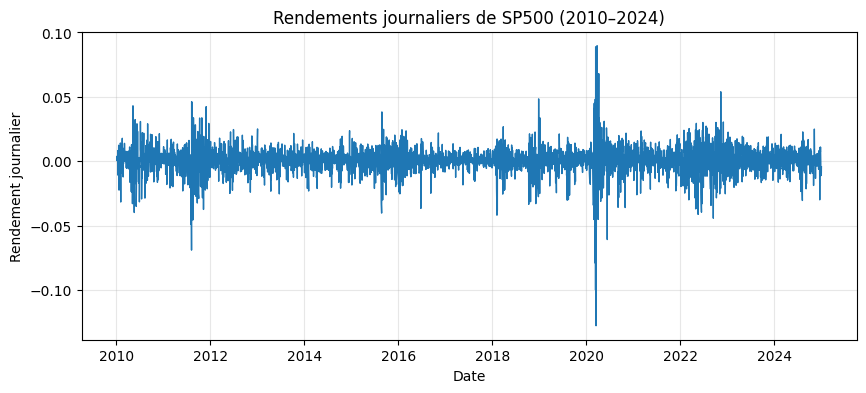

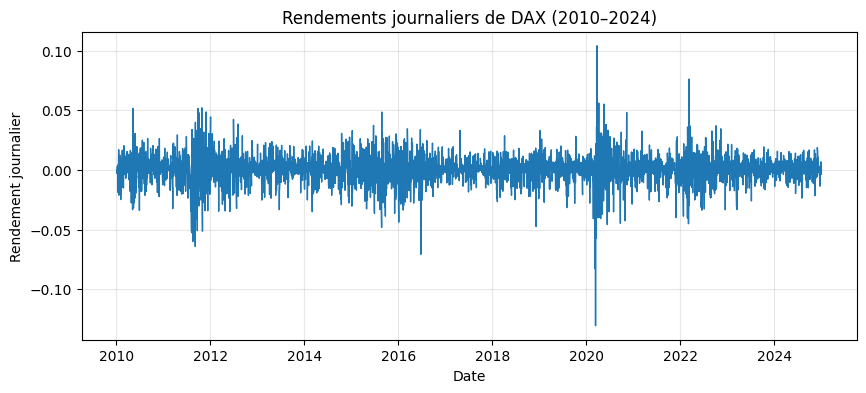

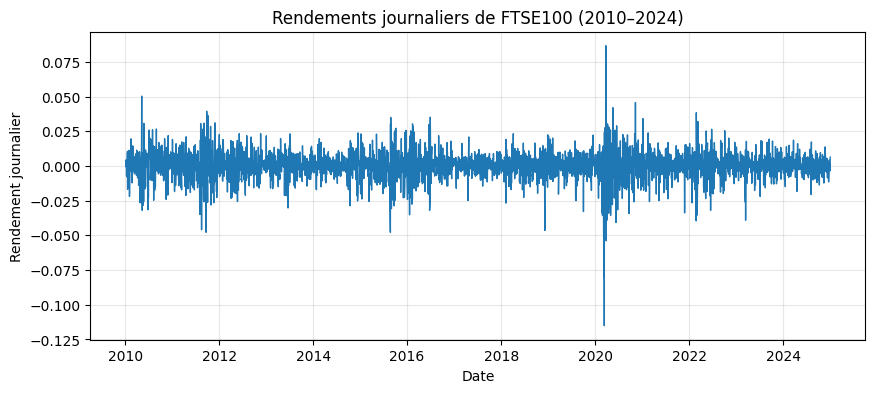

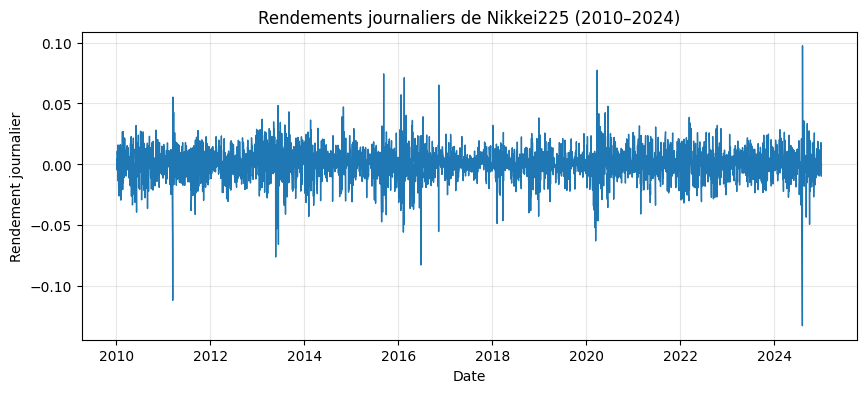

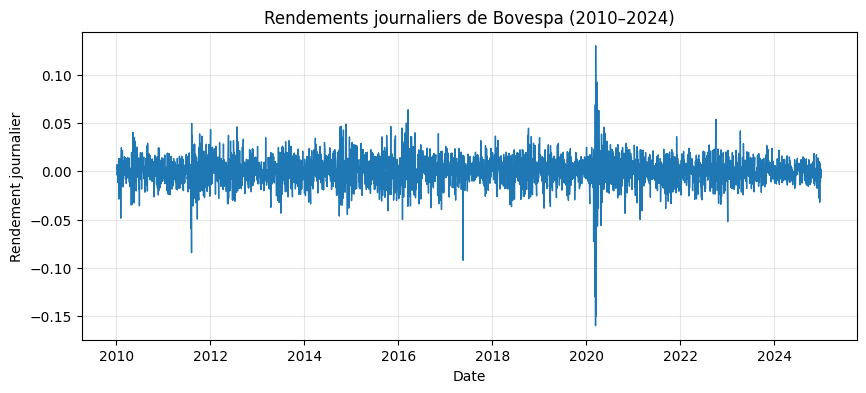

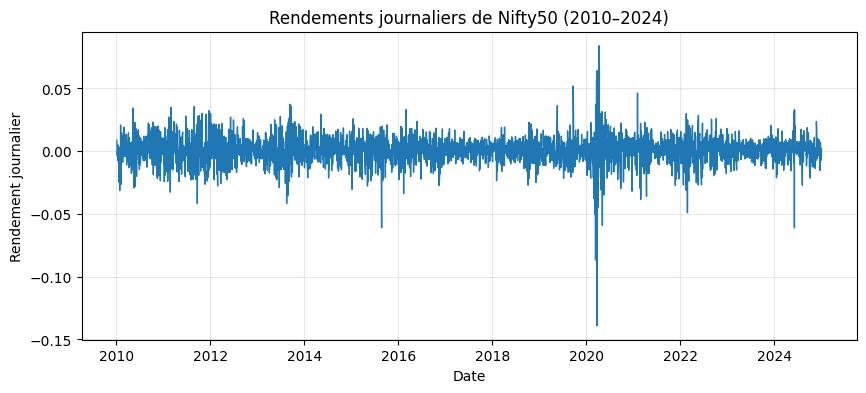

In [22]:
# Graphique des rendements journaliers
plt.figure(figsize=(12,6))
for col in returns.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(returns.index, returns[col], color='tab:blue', linewidth=1)
    plt.title(f"Rendements journaliers de {col} (2010–2024)")
    plt.xlabel("Date")
    plt.ylabel("Rendement journalier")
    plt.grid(True, alpha=0.3)
    plt.show()

In [23]:
# fenêtre 126 jours comme demandé
WIN = 126 

# Corrélation mobile entre SP500 et chaque autre indice
corr_cols = ['DAX','Nikkei225','FTSE100','Bovespa','Nifty50']
corr_mob = pd.DataFrame(index=returns.index)

for col in corr_cols:
    corr_mob[f'corr_SP500_{col}'] = returns['SP500'].rolling(WIN).corr(returns[col])

corr_mob = corr_mob.dropna()

print("Corrélations mobiles (126j) :")
print(corr_mob)
print("\nNombre d'observations par série de corrélation :")
print(corr_mob.count())

Corrélations mobiles (126j) :
            corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
2010-07-06        0.635893              0.210762            0.652437   
2010-07-07        0.633235              0.197942            0.651739   
2010-07-08        0.634284              0.206302            0.653415   
2010-07-09        0.635668              0.208772            0.654471   
2010-07-12        0.635538              0.207499            0.653911   
...                    ...                   ...                 ...   
2024-12-24        0.447845              0.369157            0.364970   
2024-12-26        0.447994              0.368094            0.366220   
2024-12-27        0.437256              0.357290            0.360101   
2024-12-30        0.439044              0.359404            0.363076   
2024-12-31        0.445482              0.357310            0.362917   

            corr_SP500_Bovespa  corr_SP500_Nifty50  
2010-07-06            0.770152            0.326947  

<Figure size 1200x600 with 0 Axes>

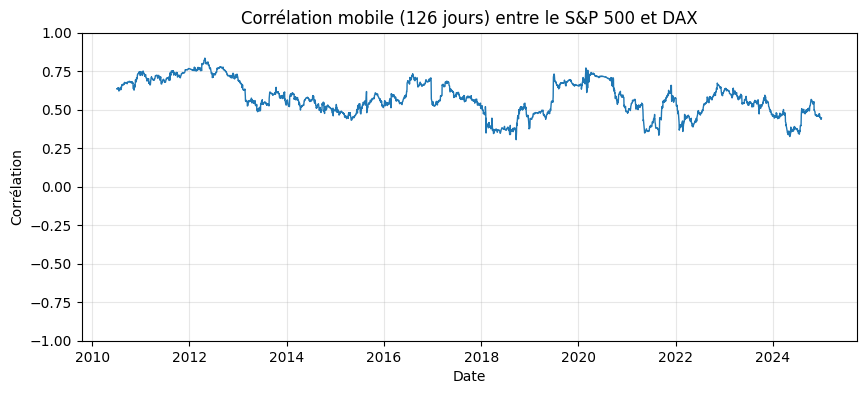

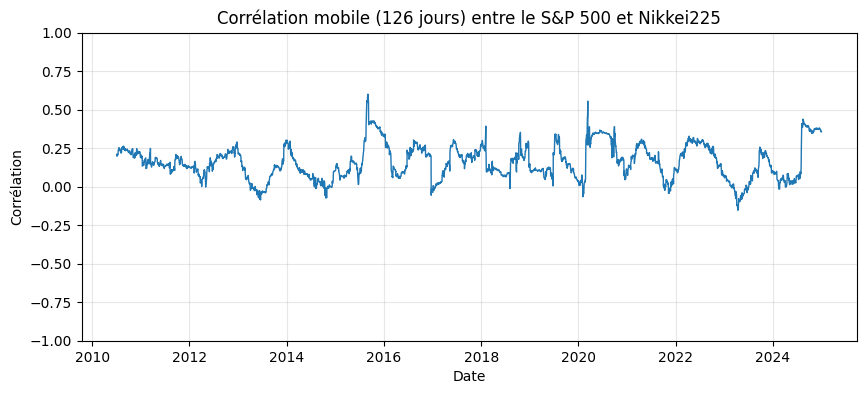

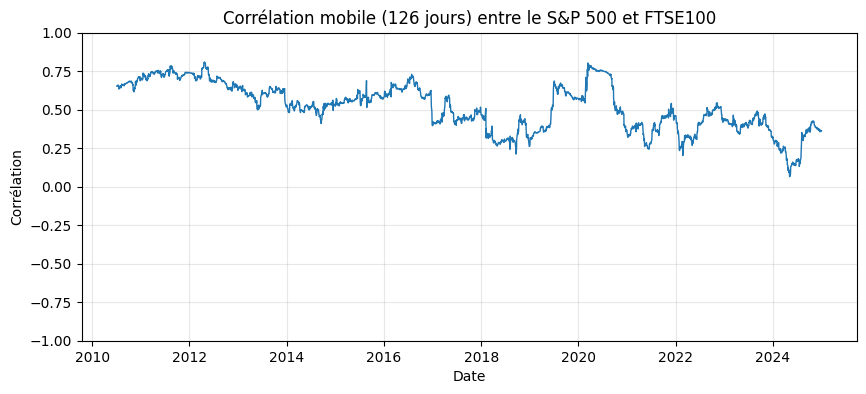

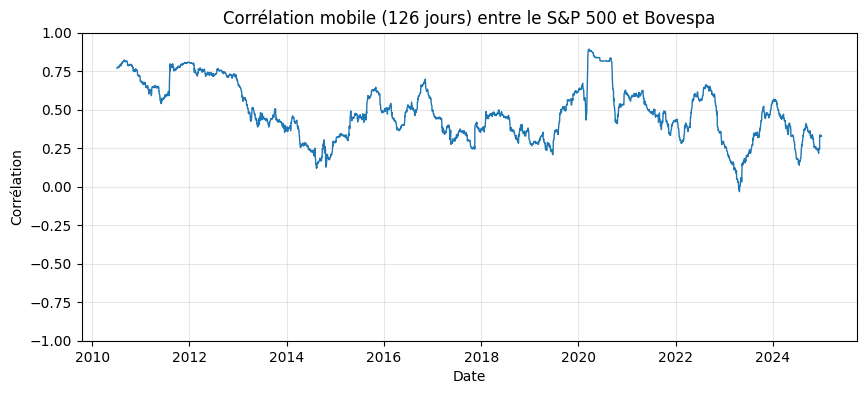

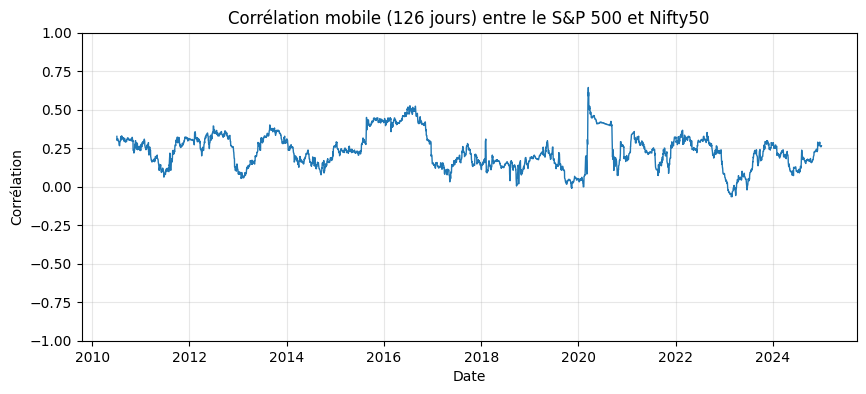

In [24]:
# Graphique des corrélations mobiles
plt.figure(figsize=(12,6))
for col in corr_mob.columns:
    plt.figure(figsize=(10,4))
    plt.plot(corr_mob.index, corr_mob[col], color='tab:blue', linewidth=1)
    plt.title(f"Corrélation mobile (126 jours) entre le S&P 500 et {col.replace('corr_SP500_', '')}")
    plt.xlabel("Date")
    plt.ylabel("Corrélation")
    plt.grid(alpha=0.3)
    plt.ylim(-1, 1)
    plt.show()

In [25]:
# Importation VIX
vix_query = """
SELECT
    date AS datadate,
    vix AS vix_value
FROM cboe.cboe
WHERE date >= '2010-01-01'
  AND date <= '2024-12-31'
  AND vix IS NOT NULL
ORDER BY date
"""

df_vix = db.raw_sql(vix_query)
df_vix['datadate'] = pd.to_datetime(df_vix['datadate'])
df_vix = df_vix.set_index('datadate')
df_vix['log_VIX'] = np.log(df_vix['vix_value'])

print("VIX :")
print(df_vix)

corr_mob_vix = corr_mob.join(df_vix['log_VIX'], how='inner').dropna()

print("\nFusion corrélations et log(VIX) :")
print(corr_mob_vix)

VIX :
            vix_value   log_VIX
datadate                       
2010-01-04      20.04   2.99773
2010-01-05      19.35  2.962692
2010-01-06      19.16  2.952825
2010-01-07      19.06  2.947592
2010-01-08      18.13  2.897568
...               ...       ...
2024-12-24      14.27  2.658159
2024-12-26      14.73  2.689886
2024-12-27      15.95  2.769459
2024-12-30       17.4   2.85647
2024-12-31      17.35  2.853593

[3793 rows x 2 columns]

Fusion corrélations et log(VIX) :
            corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
2010-07-06        0.635893              0.210762            0.652437   
2010-07-07        0.633235              0.197942            0.651739   
2010-07-08        0.634284              0.206302            0.653415   
2010-07-09        0.635668              0.208772            0.654471   
2010-07-12        0.635538              0.207499            0.653911   
...                    ...                   ...                 ...   
2024-12-24    

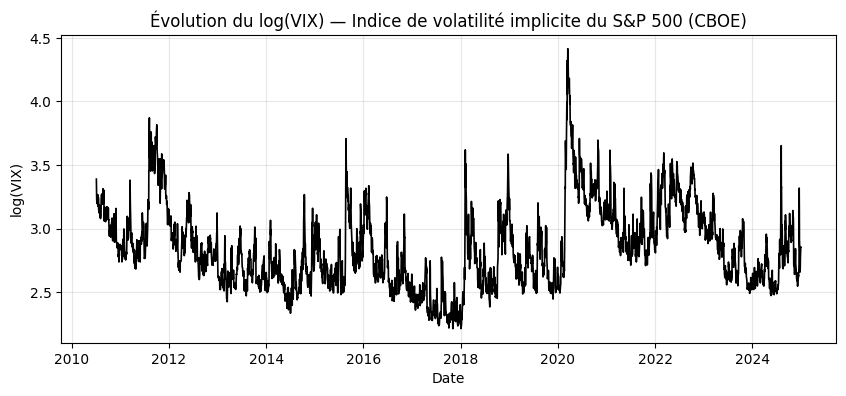

In [26]:
# Graphique log(VIX)
plt.figure(figsize=(10,4))
plt.plot(corr_mob_vix.index, corr_mob_vix['log_VIX'], color='black', linewidth=1.2)
plt.title("Évolution du log(VIX) — Indice de volatilité implicite du S&P 500 (CBOE)")
plt.xlabel("Date")
plt.ylabel("log(VIX)")
plt.grid(alpha=0.3)
plt.show()

In [27]:
# Calcul statistiques descriptives
def acf1(x):
    x = x.dropna()
    return x.autocorr(lag=1)

desc = corr_mob_vix.agg(['mean','std','min','max'])
q = corr_mob_vix.quantile([0.05,0.50,0.95])
acf1_vals = corr_mob_vix.apply(acf1)

print("Statistiques descriptives (moy, écart-type, min, max) pour chaque corrélation:")
print(desc.round(3))

print("\nQuantiles (5%, 50%, 95%) :")
print(q.round(3))

print("\nAutocorrélation au lag 1 :")
print(acf1_vals.round(3))

Statistiques descriptives (moy, écart-type, min, max) pour chaque corrélation:
      corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
mean           0.574                 0.160               0.517   
std            0.111                 0.112               0.153   
min            0.305                -0.153               0.065   
max            0.835                 0.601               0.810   

      corr_SP500_Bovespa  corr_SP500_Nifty50  log_VIX  
mean               0.483               0.231    2.846  
std                0.182               0.114    0.319  
min               -0.032              -0.065    2.213  
max                0.893               0.645    4.415  

Quantiles (5%, 50%, 95%) :
      corr_SP500_DAX  corr_SP500_Nikkei225  corr_SP500_FTSE100  \
0.05           0.375                -0.012               0.274   
0.50           0.565                 0.150               0.525   
0.95           0.751                 0.361               0.747   

      corr_SP500_

In [28]:
# Test de Dickey-Fuller Augmenté
def adf_summary(series):
    s = series.dropna()
    res = adfuller(s, regression='c', autolag='AIC')  
    out = {
        'ADF_stat': res[0],
        'p_value':  res[1],
        'lags':     res[2],
        'n_obs':    res[3]
    }
    return pd.Series(out)

adf_table = corr_mob.apply(adf_summary).T
print("Tests ADF (constante) :")
print(adf_table.round(4))

Tests ADF (constante) :
                      ADF_stat  p_value  lags   n_obs
corr_SP500_DAX         -3.0873   0.0275  17.0  3629.0
corr_SP500_Nikkei225   -4.3670   0.0003  13.0  3633.0
corr_SP500_FTSE100     -2.3787   0.1478   3.0  3643.0
corr_SP500_Bovespa     -3.0488   0.0306   6.0  3640.0
corr_SP500_Nifty50     -3.8547   0.0024   8.0  3638.0


In [29]:
# Test KPSS complémentaire
def kpss_summary(series):
    s = series.dropna()
    res = kpss(s, regression='c', nlags='auto')
    out = {
        'KPSS_stat': res[0],
        'p_value': res[1],
        'lags': res[2],
        'n_obs': len(s)
    }
    return pd.Series(out)

kpss_table = corr_mob.apply(kpss_summary).T
print("Tests KPSS (constante) :")
print(kpss_table.round(4))

Tests KPSS (constante) :
                      KPSS_stat  p_value  lags   n_obs
corr_SP500_DAX           2.5333   0.0100  38.0  3647.0
corr_SP500_Nikkei225     0.1818   0.1000  38.0  3647.0
corr_SP500_FTSE100       4.7369   0.0100  38.0  3647.0
corr_SP500_Bovespa       1.7241   0.0100  38.0  3647.0
corr_SP500_Nifty50       0.6870   0.0147  38.0  3647.0


/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2413320462.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2413320462.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2413320462.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(s, regression='c', nlags='auto')
/var/folders/bx/rtwm1h_55kq4g_m48zp38fnm0000gp/T/ipykernel_96848/2413320462.py:4: InterpolationWarning: The test st